In [24]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Softmax, Deconv2D
from keras import layers
from keras.models import Model
import multiprocessing as mp
from scipy.ndimage import convolve
import h5py

from Unet_functions import unet_create_plans, unet_stack_plans
#import CNN_functions as cnnf

%matplotlib inline

In [2]:
# Common to all plans
dim_plan_pix = np.array([200, 200])
# Neurons characteristics
cov_mean = 0
cov_std = 0.15
xvar_mean = 4.5
xvar_std = 1
yvar_mean = 4.5
yvar_std = 1

# Building first empty matrices
plan_sketch = np.zeros((0, dim_plan_pix[0], dim_plan_pix[1]))
coord_sketch = np.zeros((0, dim_plan_pix[0], dim_plan_pix[1]))

# Launching for-loop
plannum = 100
numneur = 300
numstd = 40
info_neuron = 50, 5, cov_mean, cov_std, xvar_mean, xvar_std, yvar_mean, yvar_std
plan_sketch_temp, coord_sketch_temp = unet_create_plans(plannum, dim_plan_pix, numneur, numstd, info_neuron, 5)

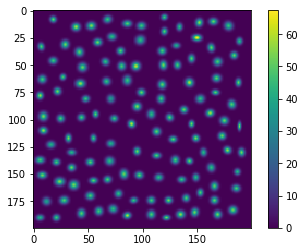

In [3]:
example = 0
plt.imshow(plan_sketch_temp[example, :, :])
plt.colorbar()

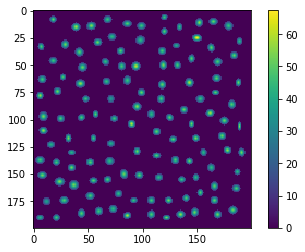

In [4]:
example = 0
plt.imshow(coord_sketch_temp[example, :, :] * plan_sketch_temp[example, :, :])
plt.colorbar()

In [5]:
# Building plans based on plan_sketch and coord_sketch
# Parameters
nstacks = 1000
stk_mean = 10
stk_std = 3
crop_size = 32
noise_mean = 0
noise_std = 0

# Launching for-loop
sk_plans, sk_coord = unet_stack_plans(nstacks, plan_sketch_temp, coord_sketch_temp, crop_size, stk_mean, stk_std, noise_mean, noise_std)
# NORMALIZING SK_PLAN
sk_plans = sk_plans / np.max(sk_plans)

# Reshaping for Unet
sk_plans_in = sk_plans.reshape(nstacks, crop_size, crop_size, 1)
max_class = int(np.max(sk_coord)) + 1
sk_coord_logits = np.zeros((nstacks, crop_size, crop_size, max_class))
for i in range(max_class):
    sk_coord_logits[:, :, :, i] = (sk_coord == i) * 1
sk_coord_logits = np.concatenate((sk_coord_logits, sk_coord_logits[:, :, :, 0].reshape(nstacks, crop_size, crop_size, 1)), axis=3)
sk_coord_logits = sk_coord_logits[:, :, :, 1:]

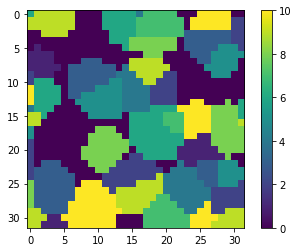

In [6]:
plt.imshow(sk_coord[0, :, :])
plt.colorbar()

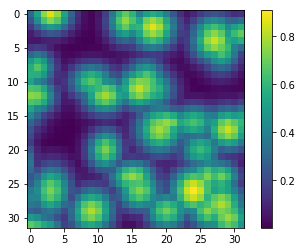

In [7]:
plt.imshow(sk_plans[0, :, :])
plt.colorbar()

In [8]:
# Keras model

# Input
sk_in = Input(shape=(crop_size, crop_size, 1))

# Convolutions
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="1st_conv")(sk_in)
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="2nd_conv")(x)
xtemp_1 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="1st_pool")(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="3rd_conv")(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="4th_conv")(x)
xtemp_2 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="2nd_pool")(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="5th_conv")(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="6th_conv")(x)
xtemp_3 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="3rd_pool")(x)
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="7th_conv")(x)
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="8th_conv")(x)
xtemp_4 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="4th_pool")(x)

# Bottom of U
x = Conv2D(1024, (3, 3), strides=(1, 1), padding="same", activation="relu", name="9th_conv")(x)

# Transposed convolutions
drate_4 = int(crop_size/32)
x = Conv2DTranspose(512, (3, 3), strides=(1, 1), padding='valid', dilation_rate=drate_4, name="1st_deconv")(x)
x = Concatenate(axis=3, name="1st_concat")([xtemp_4, x])
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="10th_conv")(x)
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="11th_conv")(x)
drate_3 = int(crop_size/16)
x = Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='valid', dilation_rate=drate_3, name="2nd_deconv")(x)
x = Concatenate(axis=3, name="2nd_concat")([xtemp_3, x])
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="12th_conv")(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="13th_conv")(x)
drate_2 = int(crop_size/8)
x = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='valid', dilation_rate=drate_2, name="3rd_deconv")(x)
x = Concatenate(axis=3, name="3rd_concat")([xtemp_2, x])
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="14th_conv")(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="15th_conv")(x)
drate_1 = int(crop_size/4)
x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='valid', dilation_rate=drate_1, name="4th_deconv")(x)
x = Concatenate(axis=3, name="4th_concat")([xtemp_1, x])
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="16th_conv")(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="17th_conv")(x)

# Final layer
x = Conv2D(max_class, (1, 1), strides=(1, 1), padding="same", name="18th_conv")(x)
sk_out = Softmax(axis=3)(x)


sk_model = Model(inputs=sk_in, outputs=sk_out)
#sk_model.summary()

In [9]:
# Fit model
sk_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
sk_model.fit(sk_plans_in, sk_coord_logits, batch_size=8, epochs=1)

Epoch 1/1
1000/1000 [==============================] - 62s 62ms/step - loss: 2.2116 - acc: 0.2710


In [10]:
#Predict for example of set
example = 0
coord_pred = sk_model.predict(sk_plans_in[example, :, :, :].reshape(1, crop_size, crop_size, 1))

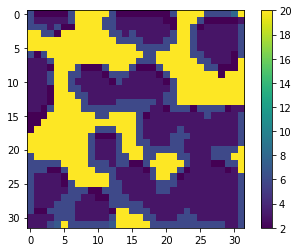

In [11]:
dplot = np.argmax(coord_pred.reshape(crop_size, crop_size, max_class), axis=2)
plt.imshow(dplot)
plt.colorbar()

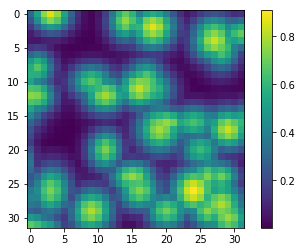

In [12]:
plt.imshow(sk_plans[example, :, :])
plt.colorbar()

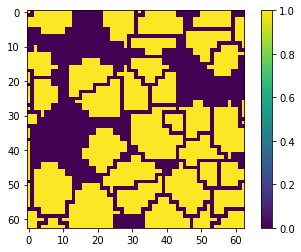

In [13]:
# Let us try to implement a mask with the segmentations
plan_temp = sk_plans[0, :, :]
coor_temp = sk_coord[0, :, :]
sk_cmask = np.zeros((2*crop_size-1, 2*crop_size-1))
# First filling
for i in range(0, 2*crop_size-1, 2):
    for j in range(0, 2*crop_size-1, 2):
        sk_cmask[i, j] = coor_temp[int(i/2), int(j/2)]
# Second filling
for i in range(1, 2*crop_size-1, 2):
    for j in range(0, 2*crop_size-1, 2):
        neighb = np.array([sk_cmask[i-1, j], sk_cmask[i+1, j]])
        if np.unique(neighb).shape[0] == 1:
            sk_cmask[i, j] = neighb[0]
# Third filling
for i in range(0, 2*crop_size-1, 2):
    for j in range(1, 2*crop_size-1, 2):
        neighb = np.array([sk_cmask[i, j-1], sk_cmask[i, j+1]])
        if np.unique(neighb).shape[0] == 1:
            sk_cmask[i, j] = neighb[0]
# Fourth filling
for i in range(1, 2*crop_size-1, 2):
    for j in range(1, 2*crop_size-1, 2):
        neighb = np.array([sk_cmask[i, j-1], sk_cmask[i, j+1], sk_cmask[i-1, j], sk_cmask[i+1, j]])
        if np.unique(neighb).shape[0] == 1:
            sk_cmask[i, j] = neighb[0]
# Replacing classes with 1s
sk_cmask[sk_cmask > 0] = 1
        
plt.imshow(sk_cmask)
plt.colorbar()

In [14]:
# Alright, let's try this segmentation on the output
new_size = 2*crop_size
sk_cmask = np.zeros([nstacks, new_size, new_size])
for stk in range(nstacks):
    coor_temp = sk_coord[stk, :, :]
    sk_cmask_temp = np.zeros((new_size, new_size))
    # First filling
    for i in range(0, new_size-1, 2):
        for j in range(0, new_size-1, 2):
            sk_cmask_temp[i, j] = coor_temp[int(i/2), int(j/2)]
    # Second filling
    for i in range(1, new_size-1, 2):
        for j in range(0, new_size-1, 2):
            neighb = np.array([sk_cmask_temp[i-1, j], sk_cmask_temp[i+1, j]])
            if np.unique(neighb).shape[0] == 1:
                sk_cmask_temp[i, j] = neighb[0]
    # Third filling
    for i in range(0, new_size-1, 2):
        for j in range(1, new_size-1, 2):
            neighb = np.array([sk_cmask_temp[i, j-1], sk_cmask_temp[i, j+1]])
            if np.unique(neighb).shape[0] == 1:
                sk_cmask_temp[i, j] = neighb[0]
    # Fourth filling
    for i in range(1, new_size-1, 2):
        for j in range(1, new_size-1, 2):
            neighb = np.array([sk_cmask_temp[i, j-1], sk_cmask_temp[i, j+1], sk_cmask_temp[i-1, j], sk_cmask_temp[i+1, j]])
            if np.unique(neighb).shape[0] == 1:
                sk_cmask_temp[i, j] = neighb[0]
    sk_cmask_temp[-1, :] = np.zeros((1, new_size))
    sk_cmask_temp[:, -1] = np.zeros((new_size))
    # Replacing classes with 1s
    sk_cmask_temp[sk_cmask_temp > 0] = 1
    # Adding to sk_cmask
    sk_cmask[stk, :, :] = sk_cmask_temp
# Reshaping
sk_cmask = sk_cmask.reshape(nstacks, new_size, new_size, 1)

# GETTING RID OF 1ST ROW AND 1ST COLUMN, FOR DECONVOLUTIONAL PURPOSE
# NOT NEEDED ANYMORE with the row an column of 0
#sk_cmask = sk_cmask[:, 1:, 1:, :]

In [15]:
# Keras model

# Input
sk_in = Input(shape=(crop_size, crop_size, 1))

# Convolutions
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="1st_conv")(sk_in)
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="2nd_conv")(x)
xtemp_1 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="1st_pool")(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="3rd_conv")(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="4th_conv")(x)
xtemp_2 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="2nd_pool")(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="5th_conv")(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="6th_conv")(x)
xtemp_3 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="3rd_pool")(x)
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="7th_conv")(x)
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="8th_conv")(x)
xtemp_4 = x
x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="4th_pool")(x)

# Bottom of U
x = Conv2D(1024, (3, 3), strides=(1, 1), padding="same", activation="relu", name="9th_conv")(x)

# Transposed convolutions
x = Conv2DTranspose(512, (1, 1), padding="valid", name="1st_deconv", strides=(2, 2))(x)
x = Concatenate(axis=3, name="1st_concat")([xtemp_4, x])
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="10th_conv")(x)
x = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="11th_conv")(x)
x = Conv2DTranspose(256, (1, 1), padding="valid", name="2nd_deconv", strides=(2, 2))(x)
x = Concatenate(axis=3, name="2nd_concat")([xtemp_3, x])
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="12th_conv")(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="13th_conv")(x)
x = Conv2DTranspose(128, (1, 1), padding="valid", name="3rd_deconv", strides=(2, 2))(x)
x = Concatenate(axis=3, name="3rd_concat")([xtemp_2, x])
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="14th_conv")(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="15th_conv")(x)
x = Conv2DTranspose(64, (1, 1), padding="valid", name="4th_deconv", strides=(2, 2))(x)
x = Concatenate(axis=3, name="4th_concat")([xtemp_1, x])
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="16th_conv")(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="17th_conv")(x)

# Final layer
x = Conv2DTranspose(64, (1, 1), padding="valid", name="5th_deconv", strides=(2, 2))(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="18th_conv")(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="19th_conv")(x)
sk_out = Conv2D(1, (1, 1), strides=(1, 1), padding="same", activation="sigmoid", name="20th_conv")(x)


sk_model = Model(inputs=sk_in, outputs=sk_out)
#sk_model.summary()

In [16]:
# Fit model
sk_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
sk_model.fit(sk_plans_in, sk_cmask, batch_size=16, epochs=10)

Epoch 1/20
1000/1000 [==============================] - 57s 57ms/step - loss: 0.4422 - acc: 0.7758
Epoch 2/20
1000/1000 [==============================] - 57s 57ms/step - loss: 0.2127 - acc: 0.9104
Epoch 3/20
1000/1000 [==============================] - 54s 54ms/step - loss: 0.1528 - acc: 0.9372
Epoch 4/20
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1279 - acc: 0.9490
Epoch 5/20
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1130 - acc: 0.9554
Epoch 6/20
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1019 - acc: 0.9602
Epoch 7/20
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0943 - acc: 0.9635
Epoch 8/20
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0836 - acc: 0.9682
Epoch 9/20
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0887 - acc: 0.9662
Epoch 10/20
 112/1000 [==>...........................] - ETA: 49s - loss: 0.0769 - acc: 0.9706

KeyboardInterrupt: 

In [17]:
#Predict for example of set
example = 0
coord_pred = sk_model.predict(sk_plans_in[example, :, :, :].reshape(1, crop_size, crop_size, 1))

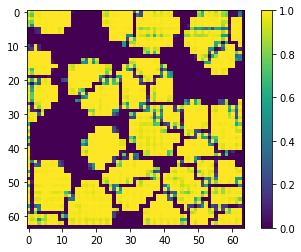

In [18]:
plt.imshow(coord_pred[example, :, :, 0])
plt.colorbar()

Shape of input matrix is  (9, 1009, 653)
Shape of matrix part that goes in the U-net is (32, 32)


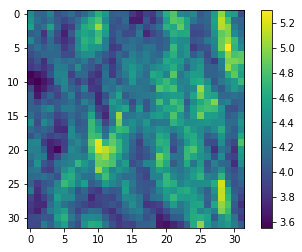

In [49]:
# Testing on actual variance dataset
# Importing file
filepath = '/home/ljp/Science/Hippolyte/mstd.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)
mstd = arrays["mstd"]
print("Shape of input matrix is ", mstd.shape)
# Taking part of that file
mstd_in = mstd[4, 50:(50+crop_size), 100:(100+crop_size)]
print("Shape of matrix part that goes in the U-net is", mstd_in.shape)
plt.imshow(mstd_in)
plt.colorbar()

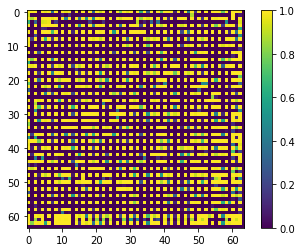

In [50]:
#Predict for actual data
coord_pred = sk_model.predict(mstd_in.reshape(1, mstd_in.shape[0], mstd_in.shape[1], 1))
plt.imshow(coord_pred[0, :, :, 0])
plt.colorbar()